Nesta atividade construiremos modelos preditivos de regressão em scikit learn para a predição dos votos de deputados federais considerando as últimas eleições. As atividades esperadas para essa etapa são descritas a seguir:

1. Baixe os dados aqui (veja descrição dos dados mais abaixo).

Vamos explorar dados sobre as votações que candidatos à Câmara Federal de Deputados receberam nos anos de 2006 e 2010. Esses dados foram extraídos do TSE (Links para um site externo)Links para um site externo, pré-processados e contemplam informações sobre aproximadamente 7.300 candidatos. A descrição de cada atributo é dada mais abaixo.

"sequencial_candidato" :(character) id do candidato

"nome": (character)

"uf": (character)

"partido": (character)

"quantidade_doacoes": (integer)

"quantidade_doadores": (integer) número de doadores diferentes

"total_receita": (double) soma em R$ das doações

"media_receita": (double) média das doações

"recursos_de_outros_candidatos/comites": (double) quantia em R$ das doações provenientes de outros candidatos ou comite partidário

"recursos_de_pessoas_fisicas": (double) quantia em R$ das doações provenientes de outros CPFs

"recursos_de_pessoas_juridicas": (double) quantia em R$ das doações provenientes de outros CNPJ

"recursos_proprios": (double) quantia em R$ das doações provenientes do próprio candidato

"recursos_de_partido_politico": (double) quantia em R$ das doações provenientes do partido político do candidato

"votos": (integer) variável alvo. Se refere ao número de votos na campanha de 2006 e 2010

"quantidade_despesas": (integer)

"quantidade_fornecedores": (integer) número de fornecedores/despesas diferentes

"total_despesa": (double) soma em R$ das despesas de campanha

"media_despesa": (double) média das despesas de campanha

"cargo": (character)

"Sexo": (character)

"grau": (character) grau de instrução do candidato

"estado_civil": (character)

"ocupacao": (character) ocupação do candidato


2. Considere o pipeline mostrado nesse [link](https://www.kaggle.com/apapiu/regularized-linear-models) para um site externo para construir seus modelos de regressão. Isso implica, dentre outras coisas:

    1. Analisar as distribuições das variáveis para ver se estão enviesadas e precisam de correção; tratamento de valores ausentes, variáveis categóricas e normalização, quando for o caso.
    2. Construir modelos de regressão com (ridge e lasso) e sem regularização.
    3. Considerar também modelos de regressão não paramétrica como K-NN.
    4. Considerar outros modelos ainda não vistos em sala de sua escolha (e.g. SVR, Regression Trees e Random Florests).
    5. Tunar os hiperâmetros para cada caso e retornar os rmses de validação cruzada para todos os modelos avaliados.
    6. Plotar os resíduos versus predições e analisar se esses plots representam bons indícios da adequabilidade dos modelos a esse problema.
    
3. Alguns dias antes da entrega final serão liberados os dados de teste referentes à 2014 para validação final dos seus melhores modelos.
    1. Dica: Uma coisa que você pode fazer é usar os dados de 2006 como treino e os de 2010 como validação. Uma vez encontrados os melhores modelos para 2010 junte 2006+2010, retreine, e aplique o modelo aos dados de 2014 que serão liberados.
    
4. Responder:
    1. Dentre os modelos avaliados, qual foi o que deu o melhor resultado nos dados de 2014 em termos de RMSE? Justifique bem sua resposta.

A entrega deve ser um notebook Jupyter com código python e texto explicativo quando necessário. Crie um repositório na sua conta do github e envie o link do html do notebook.


In [77]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.stats import skew
from scipy.stats.stats import pearsonr

## Dados 

### Leitura dos dados e divisão em treinamento e validação

In [78]:
columns = "ano sequencial_candidato nome uf partido quantidade_doacoes quantidade_doadores total_receita media_receita recursos_de_outros_candidatos/comites recursos_de_pessoas_fisicas recursos_de_pessoas_juridicas recursos_proprios quantidade_despesas quantidade_fornecedores total_despesa media_despesa cargo sexo grau estado_civil ocupacao".split() # Declare the columns names

data = pd.read_csv("dados/eleicoes_2006_a_2010.csv")
df = pd.DataFrame(data, columns=columns) # load the dataset as a pandas data frame
y = data.votos # define the target variable (dependent variable) as y

# test = pd.read_csv("../input/test.csv")

In [79]:
df.head(10)

,ano,sequencial_candidato,nome,uf,partido,quantidade_doacoes,quantidade_doadores,total_receita,media_receita,recursos_de_outros_candidatos/comites,...,recursos_proprios,quantidade_despesas,quantidade_fornecedores,total_despesa,media_despesa,cargo,sexo,grau,estado_civil,ocupacao
0,2006,10001,JOSÉ LUIZ NOGUEIRA DE SOUSA,AP,PT,6,6,16600.00,2766.666667,NaN,...,1300.00,14,14,16583.60,1184.542857,DEPUTADO FEDERAL,MASCULINO,ENSINO MÉDIO COMPLETO,CASADO(A),VEREADOR
1,2006,10002,LOIVA DE OLIVEIRA,RO,PT,13,13,22826.00,1755.846154,6625.0,...,201.00,24,23,20325.99,883.738696,DEPUTADO FEDERAL,FEMININO,SUPERIOR COMPLETO,SOLTEIRO(A),SERVIDOR PÚBLICO ESTADUAL
2,2006,10002,MARIA DALVA DE SOUZA FIGUEIREDO,AP,PT,17,16,148120.80,9257.550000,2250.0,...,59500.00,123,108,146011.70,1351.960185,DEPUTADO FEDERAL,FEMININO,SUPERIOR COMPLETO,VIÚVO(A),PEDAGOGO
3,2006,10002,ROMALDO MILANI,MS,PRONA,6,6,3001.12,500.186667,NaN,...,750.00,8,8,3001.12,375.140000,DEPUTADO FEDERAL,MASCULINO,ENSINO MÉDIO INCOMPLETO,CASADO(A),MILITAR REFORMADO
4,2006,10003,ANSELMO DE JESUS ABREU,RO,PT,48,48,NaN,NaN,NaN,...,68942.00,133,120,116416.64,970.138667,DEPUTADO FEDERAL,MASCULINO,ENSINO FUNDAMENTAL COMPLETO,CASADO(A),DEPUTADO
5,2006,10003,JOSÉ RODRIGUES DOS SANTOS NETO,PI,PCO,6,6,1771.21,295.201667,NaN,...,1771.21,9,9,1771.21,196.801111,DEPUTADO FEDERAL,MASCULINO,SUPERIOR COMPLETO,CASADO(A),SERVIDOR PÚBLICO FEDERAL
6,2006,10003,JOSÉ TOMAZ DA SILVA,MS,PRONA,14,7,697.00,99.571429,NaN,...,NaN,17,10,696.91,69.691000,DEPUTADO FEDERAL,MASCULINO,SUPERIOR COMPLETO,CASADO(A),MÉDICO
7,2006,10003,LUIZ CARLOS MUNHOZ MEIRA,MG,PPS,2,2,70000.00,35000.000000,NaN,...,70000.00,332,278,66016.95,237.471043,DEPUTADO FEDERAL,MASCULINO,SUPERIOR COMPLETO,CASADO(A),SERVIDOR PÚBLICO FEDERAL
8,2006,10004,EDILSON VEIRA ROCHA,AP,PT,2,2,6065.00,3032.500000,6065.0,...,NaN,10,10,6060.42,606.042000,DEPUTADO FEDERAL,MASCULINO,ENSINO MÉDIO COMPLETO,CASADO(A),"FEIRANTE, AMBULANTE E MASCATE"
9,2006,10004,EDUARDO VALVERDE ARAÚJO ALVES,RO,PT,68,65,105813.20,1627.895385,9575.0,...,16500.00,68,67,110818.20,1654.002985,DEPUTADO FEDERAL,MASCULINO,SUPERIOR COMPLETO,CASADO(A),DEPUTADO


In [80]:
# create training and validation vars
X_train, X_validation, y_train, y_validation = train_test_split(df, y, test_size=0.2)
print(X_train.shape, y_train.shape)
print(X_validation.shape, y_validation.shape)

(5864, 22) (5864,)
(1466, 22) (1466,)


### Pré-processamento dos dados

- **TODO Transformação das features numéricas enviesadas usando log(feature + 1) - isto tornará as features normais;**
- Substituição dos valores numéricos ausentes (NaN's) pela média de suas respectivas colunas;
- **TODO Transformação das variáveis categóricas.**

#### Enviesamento de features numéricas

Através dos histogramas abaixo vemos que as variáveis analisadas precisam de normalização, porque a distribuição dos seus valores não está igual.

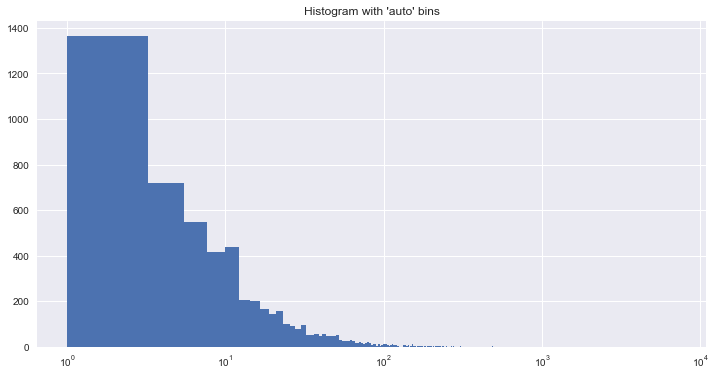

In [81]:
plt.hist(X_train["quantidade_doacoes"], bins='auto')
plt.title("Histogram with 'auto' bins")
plt.xscale('log')
plt.show()

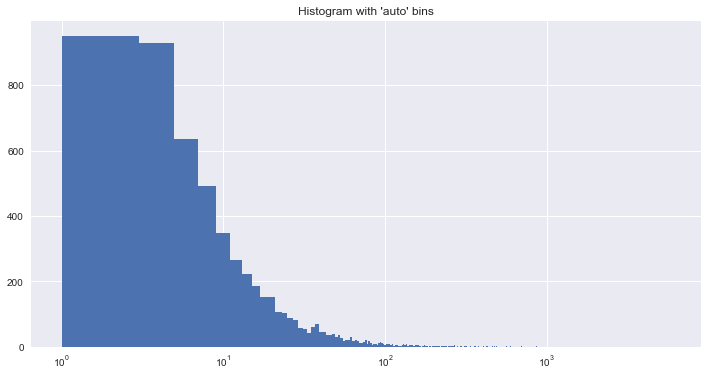

In [82]:
plt.hist(X_train["quantidade_doadores"], bins='auto')
plt.title("Histogram with 'auto' bins")
plt.xscale('log')
plt.show()

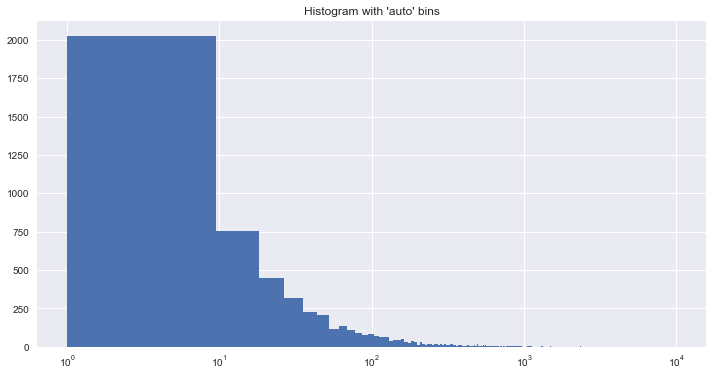

In [83]:
plt.hist(X_train["quantidade_despesas"], bins='auto')
plt.title("Histogram with 'auto' bins")
plt.xscale('log')
plt.show()

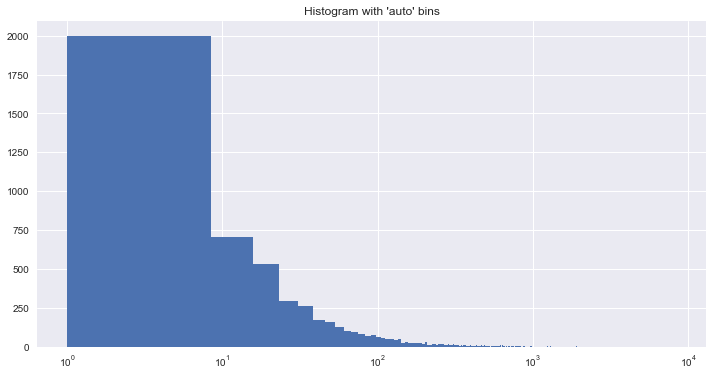

In [84]:
plt.hist(X_train["quantidade_fornecedores"], bins='auto')
plt.title("Histogram with 'auto' bins")
plt.xscale('log')
plt.show()

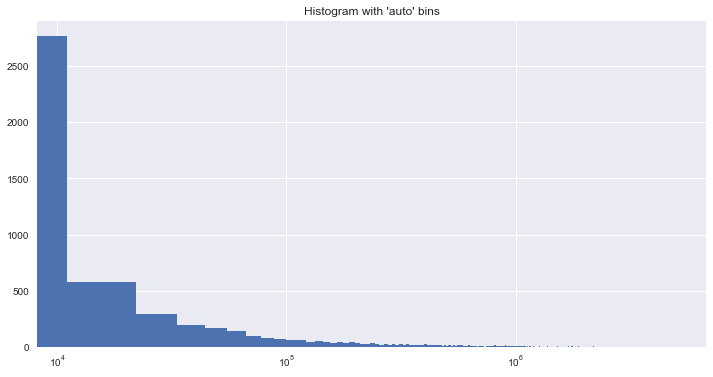

In [85]:
plt.hist(X_train["total_despesa"], bins='auto')
plt.title("Histogram with 'auto' bins")
plt.xscale('log')
plt.show()

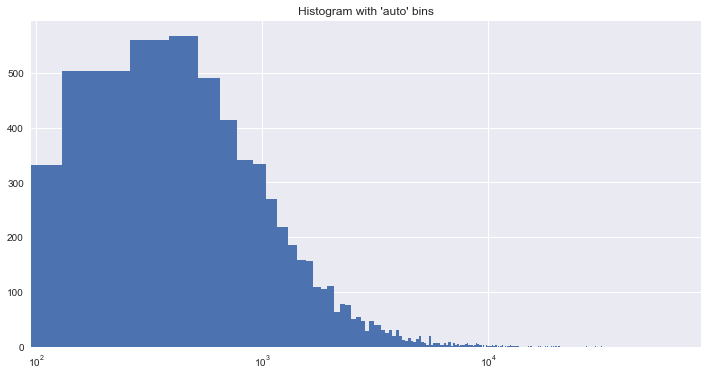

In [86]:
plt.hist(X_train["media_despesa"], bins='auto')
plt.title("Histogram with 'auto' bins")
plt.xscale('log')
plt.show()

#### Features com valores numéricos ausentes (NaN) 

Abaixo veremos quais as variáveis com valores ausentes (NaN).

In [87]:
X_train.isnull().any()

ano                                      False
sequencial_candidato                     False
nome                                     False
uf                                       False
partido                                  False
quantidade_doacoes                       False
quantidade_doadores                      False
total_receita                             True
media_receita                             True
recursos_de_outros_candidatos/comites     True
recursos_de_pessoas_fisicas               True
recursos_de_pessoas_juridicas             True
recursos_proprios                         True
quantidade_despesas                      False
quantidade_fornecedores                  False
total_despesa                            False
media_despesa                            False
cargo                                    False
sexo                                     False
grau                                     False
estado_civil                             False
ocupacao     

As variáveis **recursos_de_outros_candidatos/comites**, **recursos_de_pessoas_fisicas**, **recursos_de_pessoas_juridicas** e **recursos_proprios** são as que possuem valores ausentes e, portanto, serão substituídos pela média dos valores da respectiva variável. 

In [88]:
#filling NA's with the mean of the column:
X_train = X_train.fillna(X_train.mean())

X_train.head()

,ano,sequencial_candidato,nome,uf,partido,quantidade_doacoes,quantidade_doadores,total_receita,media_receita,recursos_de_outros_candidatos/comites,...,recursos_proprios,quantidade_despesas,quantidade_fornecedores,total_despesa,media_despesa,cargo,sexo,grau,estado_civil,ocupacao
1023,2006,10240,LAUDENOR OLIVEIRA ALBARADO,PA,PT do B,2,2,3058.52,1529.260000,29822.263167,...,3058.520000,26,22,2991.28,135.967273,DEPUTADO FEDERAL,MASCULINO,SUPERIOR COMPLETO,DIVORCIADO(A),PROFESSOR DE ENSINO MÉDIO
5508,2010,190000001734,PEDRO PAULO CARVALHO TEIXEIRA,RJ,PMDB,48,45,1462488.00,32499.733333,647048.000000,...,38824.583295,1239,391,964480.53,2466.702123,DEPUTADO FEDERAL,MASCULINO,SUPERIOR COMPLETO,CASADO(A),DEPUTADO
5361,2010,190000000712,SANDRO VITOR SILVA GONÇALVES,RJ,PMN,18,18,62084.00,3449.111111,7134.000000,...,4000.000000,40,37,60559.55,1636.744595,DEPUTADO FEDERAL,MASCULINO,SUPERIOR INCOMPLETO,CASADO(A),OUTROS
1984,2006,10628,ARACELY DE PAULA,MG,PL,46,41,357652.31,8723.227073,29822.263167,...,186552.150000,350,324,391477.31,1208.263302,DEPUTADO FEDERAL,MASCULINO,SUPERIOR COMPLETO,CASADO(A),DEPUTADO
5667,2010,190000002496,ALEXANDRE JOSE FARAH,RJ,PR,8,8,495752.72,61969.090000,2272.720000,...,2480.000000,148,96,377501.82,3932.310625,DEPUTADO FEDERAL,MASCULINO,SUPERIOR COMPLETO,DIVORCIADO(A),ADVOGADO


In [89]:
X_train.isnull().any()

ano                                      False
sequencial_candidato                     False
nome                                     False
uf                                       False
partido                                  False
quantidade_doacoes                       False
quantidade_doadores                      False
total_receita                            False
media_receita                            False
recursos_de_outros_candidatos/comites    False
recursos_de_pessoas_fisicas              False
recursos_de_pessoas_juridicas            False
recursos_proprios                        False
quantidade_despesas                      False
quantidade_fornecedores                  False
total_despesa                            False
media_despesa                            False
cargo                                    False
sexo                                     False
grau                                     False
estado_civil                             False
ocupacao     

#### Tranformação das variáveis categóricas